In [31]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [32]:
# 设置随机种子
torch.manual_seed(42)

df = pd.read_csv("../data/DataProcess/station/1037A/1037A_final.csv")
features = ['PM10', 'SO2', 'NO2', 'O3', 'CO',
       'Relative_Humidity_2m(%)', 'Temperature']
target = 'Target'

In [40]:
# 标准化特征
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(df[features])
scaled_target = scaler.fit_transform(df[[target]].values)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 将数据转换为适合 LSTM 的格式
X_scaled = scaled_features.reshape((scaled_features.shape[0], 1, scaled_features.shape[1]))
y_scaled = scaled_target.reshape((scaled_target.shape[0], 1))

# 划分数据集
train_size = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# 创建 TensorDataset
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

# 创建 DataLoader
batch_size = 3
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [41]:
# 定义一个简单的LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 实例化模型并移动到GPU
model = LSTMModel(input_size=scaled_features.shape[1], hidden_size=50, output_size=1, num_layers=2).to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [42]:
# 训练模型
for epoch in range(5):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.00024572049733251333
Epoch 2, Loss: 0.0012043049791827798
Epoch 3, Loss: 3.933781044906937e-06
Epoch 4, Loss: 0.0004637752426788211
Epoch 5, Loss: 0.0002917582169175148


In [43]:
# 模型评估
model.eval()
with torch.no_grad():
    predictions = []
    actuals = []
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(labels.cpu().numpy())
torch.save(model.state_dict(), 'lstm.pth')

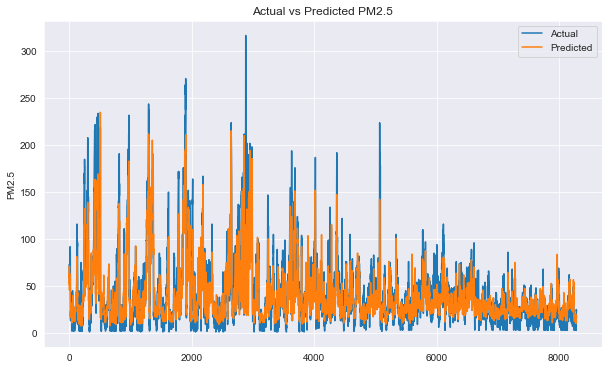

In [44]:
# 反标准化
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

# 绘制拟合曲线
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs Predicted PM2.5')
plt.ylabel('PM2.5')
plt.legend()
plt.show()


In [45]:
print(predictions[:5])
print(actuals[:5])

[[51.928883]
 [53.27902 ]
 [57.085083]
 [71.19983 ]
 [61.608162]]
[[73.      ]
 [65.      ]
 [58.      ]
 [63.000004]
 [61.000004]]


In [46]:
# 计算MAE,RMSE
rmse = np.sqrt(np.mean((predictions - actuals) ** 2))
print(f'RMSE: {rmse}')
print(f'MAE: {np.mean(np.abs(predictions - actuals))}')

RMSE: 17.849321365356445
MAE: 11.846219062805176
